In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from   dolfin import *
from   MyMods import FilePrep as fpr
from   MyMods import CustomBC as cbc
from   MyMods import CustomPropertyAssign as cpa

We begin by importing some useful standard modules such as Numpy and Matplotlib.
The entirety of FEniCS modules is imported by giving
```python 
from dolfin import *
```
Furthermore, we must import some custom modules that were created for this course.
- `FilePrep` handles file conversions and exportation
- `CustomBC` provides some methods for easy assignment of boundary conditions
- `CustomPropertyAssign` provides some methods to assign different properties to different subdomains

### The script:

In [2]:
#fname       = fpr.OpenGMSHGeom()
fname = 'central_inclusion'
mesh        = Mesh(fname + ".xml")
subdomains  = MeshFunction("size_t", mesh, fname + "_physical_region.xml")      
boundaries  = MeshFunction("size_t", mesh, fname + "_facet_region.xml")
ds          = Measure('ds', domain=mesh, subdomain_data=boundaries)
dx          = Measure('dx', domain=mesh, subdomain_data=subdomains)
volume      = 1

To load a geometry, we call the function `OpenGMSHGeom()`. This function contains a call to a graphical file explorer that allows to select a '.geo' file. Once the selection is done, the function takes care of sending the command to mesh the geometry using Gmsh, and converting the data to subdomains and boundaries information. All mesh files are stored in a subfolder named 'mesh_files'.
The `Measure` class is called to create integration partitions. We create the differential `ds` for the boundaries and `dx` for the elements surface. We also state that the domain "volume" is unitary.

We can plot the mesh to see the subdomains:

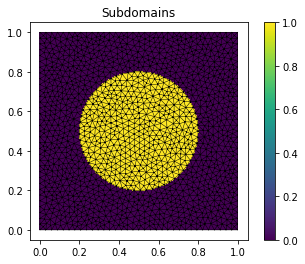

In [3]:
plt.figure(1)
plot(mesh, linewidth=0.5, color='black')
p = plot(subdomains, title='Subdomains')
plt.colorbar(p)

As can be observed from the colorbar, the center inclusion is assigned ID=1, the remaining subdomain has ID=0

In [4]:
E           = np.array([10000, 100000])                                         
nu          = np.array([0.45, 0.3])
lmbda, mu   = cpa.AssignSubPropertiesLame(mesh, subdomains, E, nu)

We assign material parameters to the subdomains: Young's Modulus (E) and Poisson's coefficient ($\nu$).
The assignment is made by creating a Numpy array where the value $i$ will be assigned to the subdomain $i$.
Once the values have been entered, they are transformed into Lamé constants and assigned to the mesh elements using the function `AssignSubPropertiesLame(mesh, subdomains, E, nu)`

The weak formulation of linear elasticity reads:

\begin{equation}
\int_{\Omega} \sigma(u) : \varepsilon(v) \: dx = \int_{\Omega} f \cdot v \: dx + \int_{\partial \Omega} t \cdot v \: ds
\end{equation}

Which is often expressed as:

\begin{equation}
a(u,v) = L(v)
\end{equation}

The solution we seek, $u$, is vector valued, so we create a suitable function space. In this function space we use some Dolfin classes to create the trial function $u$ and the test function $v$.

In [5]:
Ve          = VectorElement("CG", mesh.ufl_cell(), 2)
V           = FunctionSpace(mesh, Ve)
u           = TrialFunction(V)
v           = TestFunction(V)

If we wish to assign periodic boundary conditiond on this domain, we have to declare it now. For ease of use, two custom classes were created for this purpose:

- `cbc.Periodic_TB()` to create a mapping from the bottom to the top edges
- `cbc.Periodic_LR()` to create a mapping from the left to the right edges

These classes can be simply passed as arguments to the `FunctionSpace` class. Then in the previous block line 2 would become:

```python
V = FunctionSpace(mesh, Ve, constrained_domain=cbc.Periodic_TB())```

### Left hand side: $a(u,v)$
Let's define $\varepsilon$ and the $\sigma$ using Hooke's Law:

\begin{equation}
\varepsilon = \frac{1}{2}(\nabla u + \nabla^T u)
\end{equation}

\begin{equation}
\sigma = \lambda tr(\varepsilon)I+ 2 \mu \varepsilon
\end{equation}

In [6]:
def epsilon(u):
    return sym(grad(u))

def sigma(u):
    return lmbda*tr(epsilon(u))*Identity(2) + 2*mu*epsilon(u)

The left hand side of the weak form equation becomes simply:

In [7]:
a = inner(sigma(u), epsilon(v))*dx

### Right hand side: $L(v)$
We can define and a body force $f$ acting on the volume (first term):

In [8]:
f = Constant([0.0,0.0])
l_body = dot(f, v)*dx

Similarly we can define a uniformly distributed traction vector $t$ acting on an edge (second term). In this example, by specifying `ds(3)` we are telling FEniCS that the traction vector is acting on the boundary with ID=3 (in this case, right edge because we are following the scheme displayed).

In [9]:
t = Constant((0.0, 0.0))                                                       
l_bound = dot(t, v)*ds(3)

Finally, the right hand sides of the weak formulation of our differential equation becomes simply:

In [10]:
L = l_body + l_bound

### Boundary conditions
We create a list named `bcs`, where we will store all the Dirichlet boundary conditions. Each Dirchlet BC is created as an istance of the class `DirichletBC()`.

In [11]:
bcs = [DirichletBC(V.sub(0), Constant(0), boundaries, 1),
       DirichletBC(V.sub(0), Constant(0.2), boundaries, 3),
       DirichletBC(V, Constant((0,0)), cbc.bot_left_vertex, method='pointwise')]

<img src="BC_scheme.PNG" alt="Drawing" style="width: 300px;" align="right" />


The argument `V.sub(0)` in this case indicates that the condition is assigned only in the direction $x$ to the nodes. The second argument expresses the value of $u$ assigned. The third and fourth arguments specify the subdomain where the condition is applied. In this case, $u_x=0$ is imposed on the left edge (`boundaries, 1`), and $u_x=0.1$ is imposed on the right edge (`boundaries, 3`).


Furthermore, to make the problem isostatic, we will fix one node at the corner, where we impose $u_x, u_y=0$.
This can be convieniently done by using some custom-made functions which return the subdomain corresponding to the single node in the name. The node they localize is quite self-explainatory:

- `bot_left_vertex`
- `bot_right_vertex`
- `top_right_vertex`
- `top_left_vertex`

### Solution
We are now ready to solve the problem. We simply call the FEnicS function `solve`:

In [12]:
u = Function(V)
solve(a == L, u, bcs)

### Post processing:
Now that we have the solution $u$, we can compute $\varepsilon(u)$ and $\sigma(u)$ using the functions we had defined before. We do that in Voigt notation for easyness of reading.

We also compute the volume averaged version of these tensors, which will be useful if we wish to perform some homogenization calculations later on.

In [13]:
def Tensor2Voigt(s):
    return as_vector([s[0,0], s[1,1], s[0,1]])

sigma_voigt = Tensor2Voigt(sigma(u))
eps_voigt   = Tensor2Voigt(epsilon(u))

Sigma_avg   = np.zeros((3,))
Eps_avg     = np.zeros((3,))
for k in range(3):
    Sigma_avg[k]    = assemble(sum([sigma_voigt[k]*dx]))/volume
    Eps_avg[k]      = assemble(sum([eps_voigt[k]*dx]))/volume
    
print('Average stress in Voigt notation:', Sigma_avg)
print('Average strain in Voigt notation:', Eps_avg)

Average stress in Voigt notation: [ 3.94617420e+03 -3.12671114e-08 -2.74469368e-08]
Average strain in Voigt notation: [ 2.00000000e-01 -1.54347548e-01 -1.55835541e-07]


### Plotting:
We plot the solution just for a quick visualization of what the results gave. That's because we will export the results in Paraview format, for a better visualization of the quantities.

This is done by calling the custom function `ExportToParaview(fname, mesh, u, kwargs)`.

Remark: the three agruments of this function must always be `fname, mesh, u`. Afterwards we can give more fields as a dictionary with the structure: `NAME(str)=field_name`.

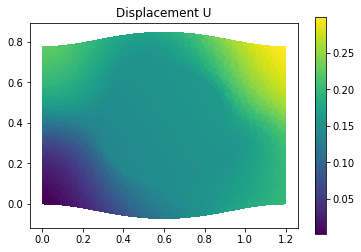

In [14]:
plt.figure(2)
p = plot(u, mode='displacement', title='Displacement U')
plt.colorbar(p)

fpr.ExportToParaview(fname, mesh, u, Sigma=sigma_voigt, Strain=eps_voigt)